In [1]:
import random
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from pytorchtools import EarlyStopping

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler


from surprise import Reader, Dataset
from surprise import SVD, evaluate
from surprise import NMF, KNNBasic
from surprise.model_selection.validation import cross_validate

# Loading the dataset

In [2]:
anime= pd.read_csv('Data/anime.csv')
ratings = pd.read_csv('Data/rating.csv')

In [3]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# Simple Analytics

In [5]:
# Shapes
print ("Anime df shape: ", anime.shape, '\n')
print ("Ratings df shape : ", ratings.shape, '\n')
print ("-------------------------------------------")

#Columns
print ("Anime df shape: ", anime.columns, '\n')
print ("Ratings df shape : ", ratings.columns, '\n')
print ("-------------------------------------------")

unique_members = anime.members.nunique()
print ('Number of unique members : ', unique_members)
unique_anime = anime.rating.nunique()
print ('Number of unique anime : ', unique_anime, '\n')

#Ratings Range
print ("-------------------------------------------")

ratings_range = ratings.rating.unique()
print ('Ratings Range : ', ratings_range)

# Handle Missing Values
print ("Users df NaN or not : \n \n", anime.isna().sum())
print ("------------------------------------------------")
print ("\n Ratings df NaN or not : \n  \n", ratings.isna().sum())
print ("------------------------------------------------")

anime.dropna(inplace=True)

print ("Users df NaN or not : \n \n", anime.isna().sum())
print ("------------------------------------------------")
print ("Anime df shape: ", anime.shape, '\n')

Anime df shape:  (12294, 7) 

Ratings df shape :  (7813737, 3) 

-------------------------------------------
Anime df shape:  Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object') 

Ratings df shape :  Index(['user_id', 'anime_id', 'rating'], dtype='object') 

-------------------------------------------
Number of unique members :  6706
Number of unique anime :  598 

-------------------------------------------
Ratings Range :  [-1 10  8  6  9  7  3  5  4  1  2]
Users df NaN or not : 
 
 anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64
------------------------------------------------

 Ratings df NaN or not : 
  
 user_id     0
anime_id    0
rating      0
dtype: int64
------------------------------------------------
Users df NaN or not : 
 
 anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64
----------------------

# More Analytics 

## Plot the counts of each rating

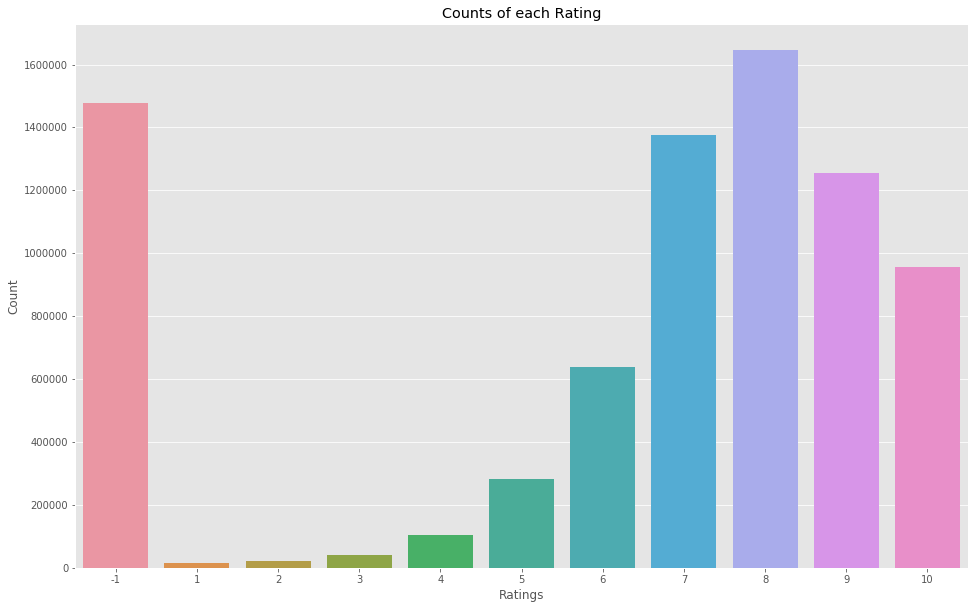

In [6]:
ratings_counts = pd.DataFrame(ratings.groupby('rating').size(), columns=['Count'])

plt.figure (figsize=(16,10))
ax = sns.barplot(x = ratings_counts.index.values, y = ratings_counts.Count.values)
ax.set(xlabel='Ratings', ylabel='Count', title = 'Counts of each Rating')
plt.show()

### Remove "-1" values

In [2]:
ratings = ratings[ratings.rating != -1]

# Plot the counts of each rating again

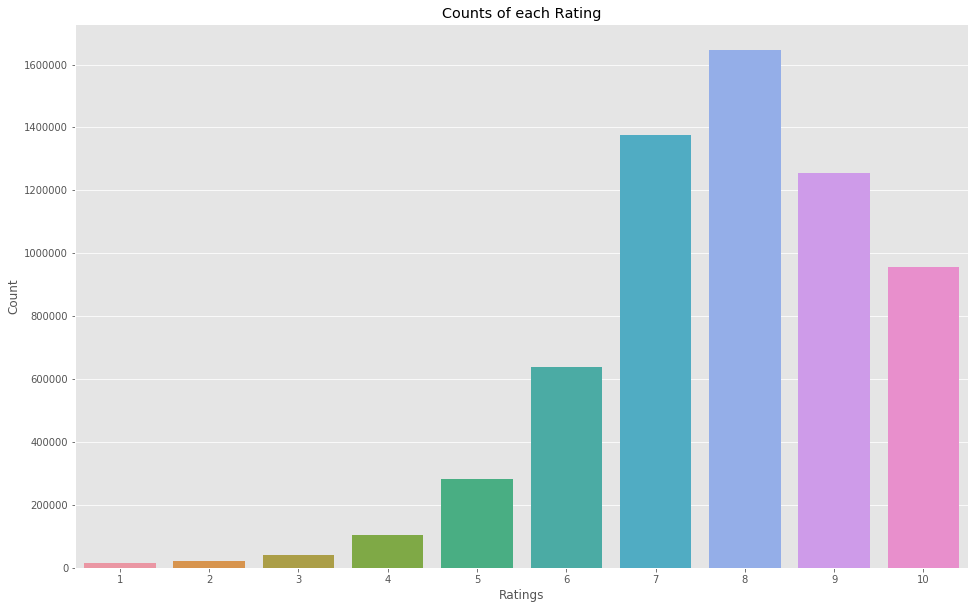

In [8]:
ratings_counts = pd.DataFrame(ratings.groupby('rating').size(), columns=['Count'])

plt.figure (figsize=(16,10))
ax = sns.barplot(x = ratings_counts.index.values, y = ratings_counts.Count.values)
ax.set(xlabel='Ratings', ylabel='Count', title = 'Counts of each Rating')
plt.show()

## Frequency of each anime got rated

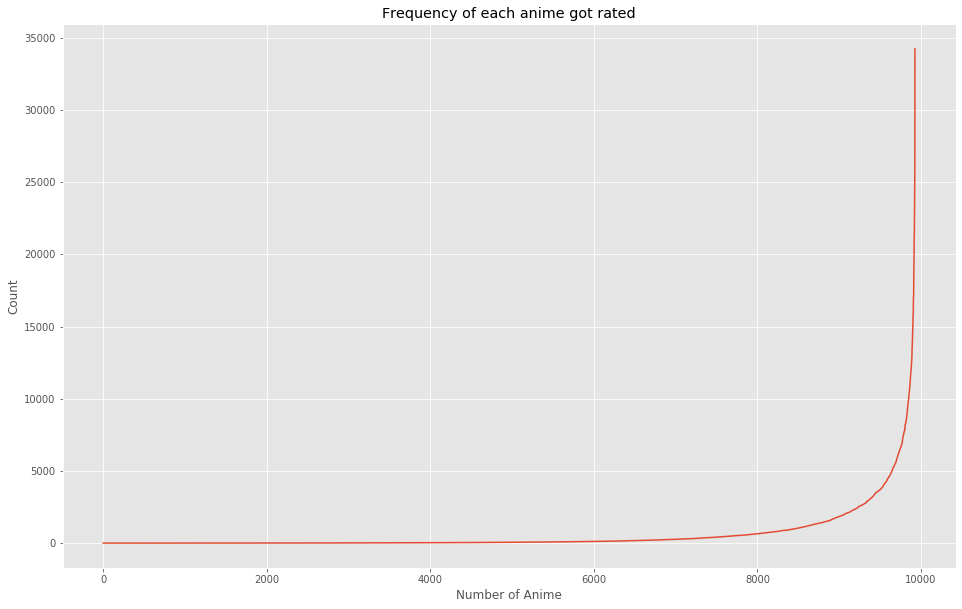

In [9]:
ratings_frequency = pd.DataFrame(ratings.groupby('anime_id').size(), columns=['Count'])
ratings_frequency_for_plot = ratings_frequency.sort_values(by='Count').reset_index(drop=True)


plt.figure (figsize=(16,10))
ax = sns.lineplot(x = ratings_frequency_for_plot.index, y = ratings_frequency_for_plot.Count)
ax.set(xlabel='Number of Anime', ylabel='Count', title = 'Frequency of each anime got rated')
plt.show()

## Set an anime rating threshold in order to avoid Long Tail Property

In [10]:
print ('Ratings shape before the removal : {}'.format(ratings.shape))
print ('Number of Anime before the removal : {}'.format(ratings.anime_id.nunique()))
print ('Number of Users before the removal : {}'.format(ratings.user_id.nunique()))

# Remove all the books with less than 100 ratings.
indexes = ratings_frequency [ratings_frequency.Count >= 500].index
ratings = ratings [ ratings.anime_id.isin( indexes ) ]

print ('Ratings shape after the removal : {}'.format(ratings.shape))
print ('Number of Anime after the removal : {}'.format(ratings.anime_id.nunique()))
print ('Number of Users before the removal : {}'.format(ratings.user_id.nunique()))

Ratings shape before the removal : (6337241, 3)
Number of Anime before the removal : 9927
Number of Users before the removal : 69600
Ratings shape after the removal : (5739865, 3)
Number of Anime after the removal : 2227
Number of Users before the removal : 69445


## Plot Frequency of each anime got rated Again

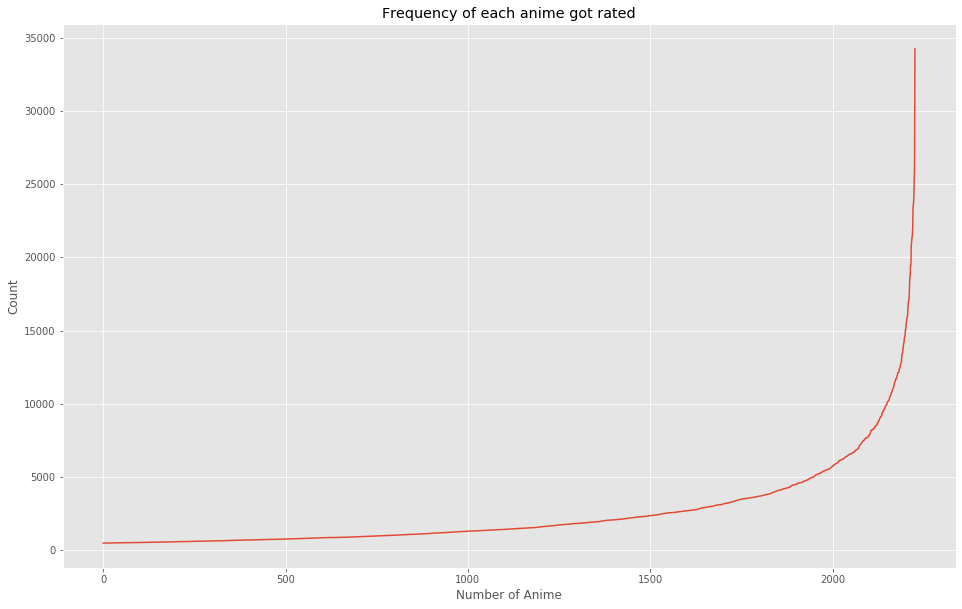

In [11]:
ratings_frequency = pd.DataFrame(ratings.groupby('anime_id').size(), columns=['Count'])
ratings_frequency_for_plot = ratings_frequency.sort_values(by='Count').reset_index(drop=True)


plt.figure (figsize=(16,10))
ax = sns.lineplot(x = ratings_frequency_for_plot.index, y = ratings_frequency_for_plot.Count)
ax.set(xlabel='Number of Anime', ylabel='Count', title = 'Frequency of each anime got rated')
plt.show()

## Plot the frequency each user is rating, in order to find the active ones 

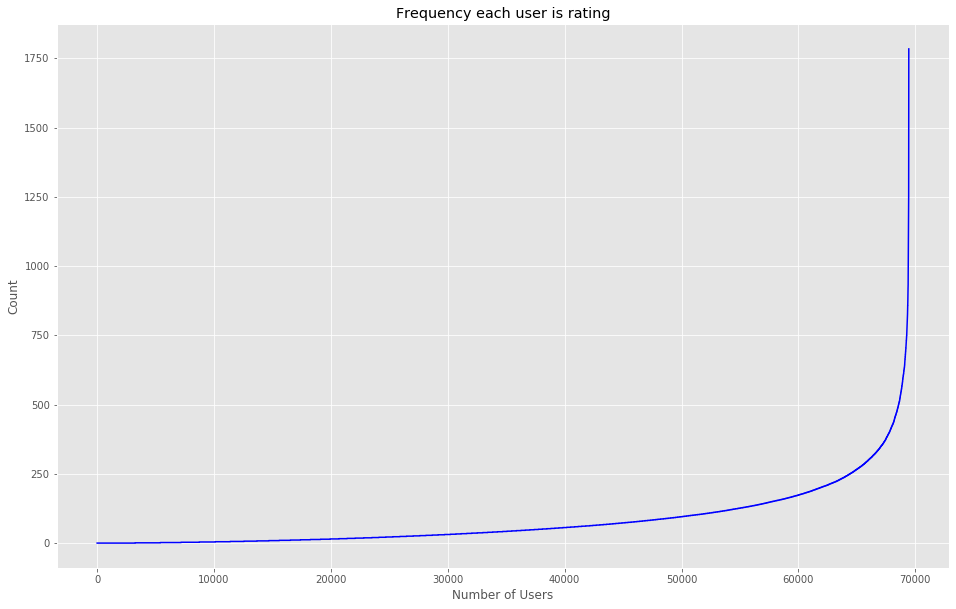

In [12]:
users_frequency = pd.DataFrame(ratings.groupby('user_id').size(), columns=['Count'])
users_frequency_for_plot = users_frequency.sort_values(by='Count').reset_index(drop=True)


plt.figure (figsize=(16,10))
ax = sns.lineplot(x = users_frequency_for_plot.index, y = users_frequency_for_plot.Count, color='blue')
ax.set(xlabel='Number of Users', ylabel='Count', title = 'Frequency each user is rating')
plt.show()

In [13]:
print ('Ratings shape before the removal : {}'.format(ratings.shape))
print ('Number of Anime before the removal : {}'.format(ratings.anime_id.nunique()))
print ('Number of Users before the removal : {}'.format(ratings.user_id.nunique()))



# Remove all the books with less than 100 ratings.
indexes = users_frequency [users_frequency.Count >= 350].index
ratings = ratings [ ratings.user_id.isin( indexes ) ]

print ('Ratings shape after the removal : {}'.format(ratings.shape))
print ('Number of Anime after the removal : {}'.format(ratings.anime_id.nunique()))
print ('Number of Users before the removal : {}'.format(ratings.user_id.nunique()))

Ratings shape before the removal : (5739865, 3)
Number of Anime before the removal : 2227
Number of Users before the removal : 69445
Ratings shape after the removal : (1207571, 3)
Number of Anime after the removal : 2227
Number of Users before the removal : 2401


## Plot the frequency each user is rating Again

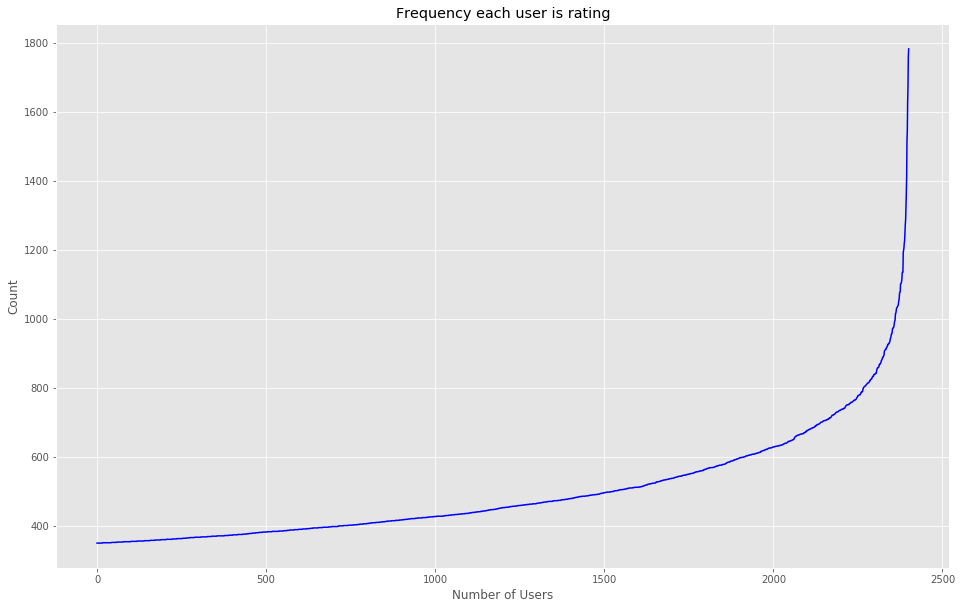

In [14]:
users_frequency = pd.DataFrame(ratings.groupby('user_id').size(), columns=['Count'])
users_frequency_for_plot = users_frequency.sort_values(by='Count').reset_index(drop=True)


plt.figure (figsize=(16,10))
ax = sns.lineplot(x = users_frequency_for_plot.index, y = users_frequency_for_plot.Count, color='blue')
ax.set(xlabel='Number of Users', ylabel='Count', title = 'Frequency each user is rating')
plt.show()

In [15]:
#Check if ratings df's UserId and anime id are contained on the other dfs
print (ratings.anime_id.isin(anime.anime_id).value_counts(), '\n')

True    1207571
Name: anime_id, dtype: int64 



# Baseline with Surprise 

In [16]:
reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings[['user_id', 'anime_id', 'rating']], reader)

# svd
algo = SVD()
print ("MSE of SVD : ", np.mean ( pow(cross_validate(algo, data, measures=['RMSE']) ['test_rmse'], 2) ) )

# nmf
algo = NMF()
print ("MSE of NMF : ", np.mean ( pow(cross_validate(algo, data, measures=['RMSE']) ['test_rmse'], 2) ) )

MSE of SVD :  1.1211930520001663
MSE of NMF :  4.317033925832879


# Neural Network Approach

## Define Dataset Class

In [17]:
class AnimeDataset (Dataset):
    
    def __init__ (self, ratings):
    
        self.ratings = ratings
        
    def __len__ (self):
        return len(self.ratings)
    
    def __getitem__ (self, index):
        
        rating = self.ratings['rating'].iloc[index]
        user = self.ratings['UsersInt'].iloc[index]
        anime = self.ratings['AnimeInt'].iloc[index]
        
        return {'rating' : rating, 'user' : user, 'anime' : anime}

## Define Neural Network Architecture

In [18]:
def get_emb(num_item,num_emb):
    emb = nn.Embedding(num_item, num_emb)
    emb.weight.data.uniform_(-0.01,0.01)
    #emb.weight.data.normal_(0,0.003)

    return emb

class EmbeddingNet (nn.Module):
    
    def __init__ (self, num_users, num_anime, num_emb, hidden_dim, drop1=0.05, drop2=0.5):
        
        super(EmbeddingNet, self).__init__()
        
        #We create one embedding for both users and books. It's smthing like the matrix factorization
        #They are basicaly the weights of the network
        self.user_emb = get_emb(num_users, num_emb)
        self.anime_emb = get_emb(num_anime, num_emb)

        #Its * 2 cause we concacenated the two embeddings
        self.dense1 = nn.Linear(num_emb*2, hidden_dim)  # bias is True by default
        self.dense2 = nn.Linear(hidden_dim, 1)
        self.drop1 = nn.Dropout(p = drop1)
        self.drop2 = nn.Dropout(p = drop2)
        
    def forward (self, batch_users, batch_anime ):
        '''
        forward pass i.e. :
        dot product of vector from books embedding matrixx and vector from user embeddings matrix
        
        # torch.cat : concatenates both embedding matrix to make more columns, same rows i.e. n_factors*2, n : rows
        # u(users) is doing lookup for indexed mentioned in users
        # users has indexes to lookup in embedding matrix. 
        '''
        user_emb_out = self.user_emb(batch_users)
        anime_emb_out = self.anime_emb(batch_anime)
        connected_one_next_to_the_other = torch.cat([user_emb_out,anime_emb_out], 1)
        
        x = self.drop1(connected_one_next_to_the_other) # drop initialized weights
        x = self.drop2(F.relu(self.dense1(x))) # drop 1st linear + nonlinear wt
        
        #This is used to restrict the predictions between the max and the min rating.
        r = torch.sigmoid(self.dense2(x)) * (max_rating - min_rating + 1) #+ min_rating - 0.5       
        return r

## Define the training Function

In [19]:
def train_model (number_of_epoch, model, patience):    
    
    #Initialize Early Stop counter
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(number_of_epoch):

        for phase in ['train', 'validation']:

            if phase == 'train':
                model.train()
            if phase == 'validation':
                model.eval()

            running_loss = 0.0

            for batch in dataloaders [phase]:

                batch_users = batch['user']
                batch_users = batch_users.cuda()
                batch_anime = batch['anime']
                batch_anime = batch_anime.cuda()
                batch_ratings = batch['rating'].view(-1,1).float()
                batch_ratings = batch_ratings.cuda()

                if phase == 'train':
                    optimizer.zero_grad()

                output = model(batch_users, batch_anime)
                loss =F.mse_loss(output, batch_ratings)
                running_loss += loss.item()

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss = running_loss / len(dataloaders [phase])
            print("Epoch : ", epoch, ", phase : ", phase, "loss : " ,epoch_loss)
            
    
            if (phase == 'train') :
                train_loss = epoch_loss
            if (phase == 'validation') :
                validation_loss = epoch_loss
                
        early_stopping(validation_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model, train_loss, validation_loss

# Encode the User Id's and Anime Id's with sequential integers, so the embedding layers will be smaller

In [20]:
user_encoder = LabelEncoder()
anime_encoder = LabelEncoder()

user_encoder.fit(ratings.user_id.unique())
ratings['UsersInt'] = ratings.user_id.map(lambda x : user_encoder.transform([x])[0])

anime_encoder.fit(ratings.anime_id.unique())
ratings['AnimeInt'] = ratings.anime_id.map(lambda x : anime_encoder.transform([x])[0])

ratings.head()

,user_id,anime_id,rating,UsersInt,AnimeInt
302,5,6,8,0,2
303,5,15,6,0,4
304,5,17,6,0,6
305,5,18,6,0,7
306,5,20,6,0,9


## Define the arguments

In [21]:
# Dataset Arguments
shuffle_dataset = True
batch_size = 128

# Model Arguments
wd=1e-5
learning_rate = 0.01

# Training Arguments
number_of_splits = 3
number_of_epoch = 10
patience = 3

# Users Embedding Matrix Row Dimension
num_users = ratings.UsersInt.max() +1
print (num_users)
# Books Embedding Matrix RowDimension
num_anime = ratings.AnimeInt.max() +1
print (num_anime)


# Min Max Rating
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

2401
2227


(1, 10)

## I keep 20% of the data for testings  and from the other 80% I do K-Fold Cross Validation with 30% for validation.

In [22]:
#Load Dataset
dataset = AnimeDataset(ratings)

dataset_split = int ( len(dataset) * 0.8 )
indices = list(range( len(dataset) ))

if shuffle_dataset :
        np.random.seed( random.randint(1,100) )
        np.random.shuffle(indices)
            
main_indices = indices[:dataset_split]
test_indices = indices[dataset_split:]
print ('\n Train on : {} instances, Test on : {}'.format(len(main_indices), len(test_indices)))

       
'''CROSS VALIDATION'''
# Initalize for cross validation
train_losses = []
validation_losses = []

for split in range(number_of_splits) :
    
    
    '''CREATE THE LOADERS'''

    #Spliting
    train_split = int ( len(main_indices) * 0.7 ) 

    # Creating data indices for training and validation splits:
    indices = main_indices

    if shuffle_dataset :
        np.random.seed( random.randint(1,100) )
        np.random.shuffle(indices)

    train_indices = indices[:train_split]
    val_indices = indices[train_split:]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader (dataset = dataset, batch_size = batch_size, sampler = train_sampler, drop_last=True)
    validation_loader = DataLoader (dataset = dataset, batch_size = batch_size, sampler = valid_sampler, drop_last=True)

    dataloaders = {'train' : train_loader, 'validation' : validation_loader}
    dataloaders_size = {'train' : len(train_loader), 'validation' : len(validation_loader)}
    
    
    '''DEFINE THE MODEL'''
    
    # Model
    model = EmbeddingNet(num_users=num_users, num_anime=num_anime, num_emb = 100, hidden_dim=100)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=wd)
    
    if (split == 0) :
        
        print ('\n Train on : {} instances, Validate on : {}'.format(len(train_indices), len(val_indices)))
        
        print ('\n The model\'s architecture is : \n',   model)
    
    '''Train the model'''
    
    print ('\n Split : ', split+1)
    trained_model, train_loss, validation_loss = train_model(number_of_epoch, model, patience)
    
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    

final_train_loss = np.sum(train_losses)/number_of_splits
final_validation_loss = np.sum(validation_losses)/number_of_splits
print ("\n After {} - Fold Cross Validation, we got {} MSE on training and {} MSE on validation. \n".format
       (number_of_splits, final_train_loss, final_validation_loss))


 Train on : 966056 instances, Test on : 241515

 Train on : 676239 instances, Validate on : 289817

 The model's architecture is : 
 EmbeddingNet(
  (user_emb): Embedding(2401, 100)
  (anime_emb): Embedding(2227, 100)
  (dense1): Linear(in_features=200, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=1, bias=True)
  (drop1): Dropout(p=0.05, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
)

 Split :  1
Epoch :  0 , phase :  train loss :  1.544879015356714
Epoch :  0 , phase :  validation loss :  1.3871447772261531
Validation loss decreased (inf --> 1.387145).  Saving model ...
Epoch :  1 , phase :  train loss :  1.4691684667233285
Epoch :  1 , phase :  validation loss :  1.328831345448435
Validation loss decreased (1.387145 --> 1.328831).  Saving model ...
Epoch :  2 , phase :  train loss :  1.4484689945459772
Epoch :  2 , phase :  validation loss :  1.3249714572259057
Validation loss decreased (1.328831 --> 1.324971).  Saving model ...
Epoch :  3

## Train the final Model from all the data which were used for cross validation[80% of all the data], for 2 epoches, cause we saw, that after that the model overfitted, and test that to the test data[20%] which were kept separate before.

In [23]:
'''Create the final Model from all the dataset'''
#Dataset 
main_sampler = SubsetRandomSampler(main_indices)
main_loader = DataLoader (dataset = dataset, batch_size = batch_size, sampler = main_sampler, drop_last=True)
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader (dataset = dataset, batch_size = batch_size, sampler = test_sampler, drop_last=True)

# Model
model = EmbeddingNet(num_users=num_users, num_anime=num_anime, num_emb = 100, hidden_dim=100)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=wd)

#Train the model from all the training dataset
for epoch in range(3):
    model.train()
    running_loss = 0.0
    for batch in main_loader:
        batch_users = batch['user']
        batch_users = batch_users.cuda()
        batch_anime = batch['anime']
        batch_anime = batch_anime.cuda()
        batch_ratings = batch['rating'].view(-1,1).float()
        batch_ratings = batch_ratings.cuda()
        
        optimizer.zero_grad()

        output = model(batch_users, batch_anime)
        loss =F.mse_loss(output, batch_ratings)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(main_loader)
    print("Epoch : ", epoch,"loss : " ,epoch_loss)    
    
    
#Test the model
running_loss = 0.0
for batch in test_loader:
    batch_users = batch['user']
    batch_users = batch_users.cuda()
    batch_anime = batch['anime']
    batch_anime = batch_anime.cuda()
    batch_ratings = batch['rating'].view(-1,1).float()
    batch_ratings = batch_ratings.cuda()
    
    output = model(batch_users, batch_anime)
    loss =F.mse_loss(output, batch_ratings)
    running_loss += loss.item()

test_loss = running_loss / len(test_loader)
print("\n Test Loss : ", test_loss)

Epoch :  0 loss :  1.5278554120584404
Epoch :  1 loss :  1.4593460184541842
Epoch :  2 loss :  1.4498218822608773

 Test Loss :  1.4740730678605376


## Recommend the top 10 anime for a specific user.

In [33]:
'''Collect the data for a specific user'''
# Take one random of the users who left.
user_id = np.random.choice(ratings.UsersInt.unique())

# Isolate all the indexes of the remaining anime.
anime_user_never_read = ratings.loc [ratings.user_id != user_id]
all_anime_indexes = torch.Tensor(anime_user_never_read.AnimeInt.unique()).long().cuda()

# Create an empty tensor with the same length with the anime
empty_tensor = torch.Tensor( len(all_anime_indexes) )
# Fill it with the user id
user_a_lot = empty_tensor.fill_(user_id) 
user_a_lot = user_a_lot.long().cuda()



'''Prediction of the top 10 anime recommendations for the user'''    
preds = model(user_a_lot, all_anime_indexes)

#Find top 10 anime
predicted_ratings, top_10_anime_pos = preds.flatten().topk(10)
top_10_anime_idxs = all_anime_indexes[top_10_anime_pos]
top_10_anime = anime_encoder.inverse_transform (top_10_anime_idxs.cpu())

results = anime.set_index('anime_id').loc[top_10_anime].reset_index()
results['Predicted_Rating'] = predicted_ratings.tolist() 
results['Predicted_Rating'] = results['Predicted_Rating'].map(round)
results

,anime_id,name,genre,type,episodes,rating,members,Predicted_Rating
0,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,10
1,19,Monster,"Drama, Horror, Mystery, Police, Psychological,...",TV,74,8.72,247562,10
2,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,10
3,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679,9
4,25835,Shirobako,"Comedy, Drama",TV,24,8.49,146895,9
5,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824,9
6,2001,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,27,8.78,562962,9
7,57,Beck,"Comedy, Drama, Music, Shounen, Slice of Life",TV,26,8.40,148328,9
8,11577,Steins;Gate Movie: Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller",Movie,1,8.61,192424,9
9,5205,Kara no Kyoukai 7: Satsujin Kousatsu (Kou),"Action, Mystery, Romance, Supernatural, Thriller",Movie,1,8.57,95658,9
